In [8]:
import sys
import socket

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    sys.path.extend(['/home/jorg/repository/seg_eval_pipeline'])
else:
    sys.path.extend(['/home/jorg/repo/seg_eval_pipeline'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch
import dill
import os
import glob
import SimpleITK as sitk

from io_tools.acdc.data_handler_phase import ACDCDataHandlerPhase
from io_tools.acdc.detector_dataset import RegionDetectorDataSet
from io_tools.acdc.create_detector_dataset import create_dataset
from config.dcnn.general_setup import base_config as dcnn_config
from config.region_detector.general_setup import config_detector
from config.region_detector.general_setup_voxel_detector import config_voxel_detector

from utils.region_detector.heat_map import ImageHeatMapHandler

from utils.region_detector.batch_handler import BatchHandler
from utils.region_detector.batch_handler_voxelbase import BatchHandlerVoxelDetection
from models.region_detector.model_handler import ModelHandler

from plotting.color_maps import transparent_cmap


mycmap = transparent_cmap(plt.get_cmap('plasma'))

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Ready")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ready


In [10]:
# heat_map_handler = ImageHeatMapHandler()
# heat_map_handler.load(input_dir="/home/jorg/models/region_detector/rd1/heat_maps/e_map/")
fold_id = 0
data_handler = ACDCDataHandlerPhase(dcnn_config, loss_function="brier")
data_handler.initialize(fold_id=fold_id)

['patient016', 'patient017', 'patient018', 'patient019', 'patient020', 'patient036', 'patient037', 'patient038', 'patient039', 'patient040', 'patient056', 'patient057', 'patient058', 'patient059', 'patient060', 'patient076', 'patient077', 'patient078', 'patient079', 'patient080', 'patient096', 'patient097', 'patient098', 'patient099', 'patient100']


/home/jorg/anaconda2/envs/pyt_1_0_0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [25]:
from scipy.ndimage import gaussian_filter

patient_id = "patient098"
cardiac_phase = "ES"
bmap = data_handler.get_bayes_umap(patient_id, cardiac_phase, force_reload=True)
emap = data_handler.get_entropy_maps(patient_id, cardiac_phase, force_reload=True)
smoothed_emap = np.zeros_like(emap)
for z in range(emap.shape[2]):
    sigma = 0.5
    smoothed_emap[..., z] = gaussian_filter(emap[..., z], sigma)
smoothed_emap[smoothed_emap <= 0.75] = 0
print(np.min(bmap), np.max(bmap))
print(np.min(emap), np.max(emap))
print(np.min(smoothed_emap), np.max(smoothed_emap))


1.5145736e-05 0.8413462
9.488814e-07 0.9950684
0.0 0.96224564


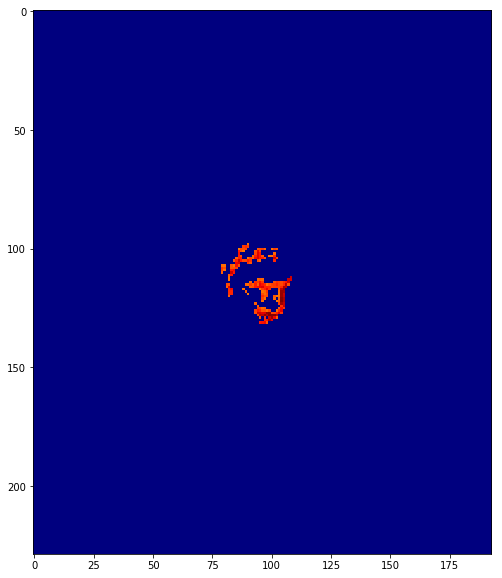

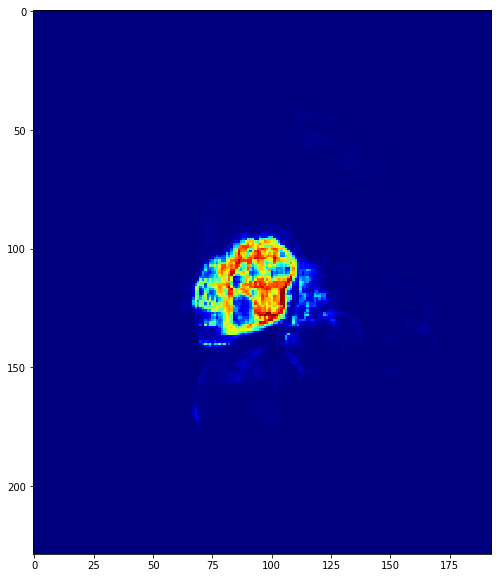

In [35]:
slice_id = 6

plt.rcParams['figure.figsize'] = [12.0, 10.0]
plt.imshow(smoothed_emap[...,slice_id], cmap=cm.jet)
plt.show()
plt.imshow(emap[...,slice_id], cmap=cm.jet)
plt.show()

In [33]:
mc_dropout = False
patient_id = "patient098"
cardiac_phase = "ES"
RS = 123

features = data_handler.get_features(patient_id, cardiac_phase, mc_dropout=mc_dropout)
pred_labels = data_handler.get_pred_labels(patient_id, cardiac_phase, mc_dropout=mc_dropout, force_reload=True)
bmap = data_handler.get_bayes_umap(patient_id, cardiac_phase, force_reload=True)
emap = data_handler.get_entropy_maps(patient_id, cardiac_phase, force_reload=True)

bmap *= 2
emap *= 0.5
print(np.max(bmap), np.max(emap), np.count_nonzero(bmap>=threshold), np.count_nonzero(emap>=threshold))
threshold = 0.06

ref_labels = data_handler.get_label(patient_id, cardiac_phase)

multi_ref_labels = np.argmax(ref_labels, axis=0)
multi_pred_labels = np.argmax(pred_labels, axis=0)
extended_features = np.concatenate((features, bmap[np.newaxis]), axis=0)
print(multi_ref_labels.shape, np.unique(multi_ref_labels))
print(features.shape, ref_labels.shape, extended_features.shape)
voxel_indices = multi_ref_labels != 0

bmap_filtered = bmap[voxel_indices]
emap_filtered = emap[voxel_indices]
bmap_targets = np.zeros_like(bmap_filtered)
emap_targets = np.zeros_like(emap_filtered)
bmap_targets[bmap_filtered >= threshold] = 1
emap_targets[emap_filtered >= threshold] = 1
print(np.count_nonzero(bmap_targets), np.count_nonzero(emap_targets))

target_labels = multi_ref_labels[voxel_indices]
target_pred_labels = multi_pred_labels[voxel_indices]

target_features = np.transpose(features[:, voxel_indices], (1, 0))
extended_features = np.transpose(extended_features[:, voxel_indices], (1, 0))
# we omit background classes but shift class values from 1-3 to 0-2
adjusted_labels = np.zeros_like(target_labels)
adjusted_labels[target_labels == 2] = 1
adjusted_labels[target_labels == 3] = 2
target_labels = adjusted_labels
print(voxel_indices.shape, target_features.shape, extended_features.shape , target_labels.shape,
     bmap_targets.shape)

0.9184627 0.99391335 18242 13346
(229, 193, 7) [0 1 2 3]
(128, 229, 193, 7) (4, 229, 193, 7) (129, 229, 193, 7)
11442 7595
(229, 193, 7) (15567, 128) (15567, 129) (15567,) (15567,)


In [57]:
mc_dropout = False
patient_id = "patient098"
cardiac_phase = "ES"
RS = 123

features = data_handler.get_features(patient_id, cardiac_phase, mc_dropout=mc_dropout)
pred_labels = data_handler.get_pred_labels(patient_id, cardiac_phase, mc_dropout=mc_dropout, force_reload=True)
bmap = data_handler.get_bayes_umap(patient_id, cardiac_phase, force_reload=True)
emap = data_handler.get_entropy_maps(patient_id, cardiac_phase, force_reload=True)

bmap *= 2
emap *= 0.5
threshold = 0.06

ref_labels = data_handler.get_label(patient_id, cardiac_phase)

multi_ref_labels = np.argmax(ref_labels, axis=0)
multi_pred_labels = np.argmax(pred_labels, axis=0)
extended_features = np.concatenate((features, bmap[np.newaxis]), axis=0)


bmap_targets = np.zeros_like(bmap)
emap_targets = np.zeros_like(emap)
bmap_targets[bmap >= threshold] = 1
emap_targets[emap >= threshold] = 1
print(features.shape, extended_features.shape)

multi_ref_labels = multi_ref_labels.flatten()
target_features = np.transpose(np.reshape(features, (features.shape[0], -1)), (1, 0))
extended_features = np.transpose(np.reshape(extended_features, (extended_features.shape[0], -1)), (1, 0))

print(target_features.shape, extended_features.shape , multi_ref_labels.shape, bmap_targets.shape)

(128, 229, 193, 7) (129, 229, 193, 7)
(309379, 128) (309379, 129) (229, 193, 7)


In [7]:
from sklearn.decomposition import PCA
from plotting.tsne_scatter import fashion_scatter

dt_ref_labels = data_handler.get_detector_target_labels(patient_id, cardiac_phase, mc_dropout=mc_dropout)
dt_ref_multi_labels = np.any(dt_ref_labels, axis=0)
dt_ref_multi_labels = dt_ref_multi_labels[voxel_indices]

extended_features_emap = np.concatenate((features, emap[np.newaxis]), axis=0)

print(target_features.shape, extended_features_emap.shape, emap.shape, dt_ref_multi_labels.shape)


(15567, 128) (129, 229, 193, 7) (229, 193, 7) (15567,)


In [43]:
print(pca_result.shape, bmap_filtered.shape)
reduced_features = np.concatenate((pca_result, bmap_filtered[:, np.newaxis]), axis=1)
print(reduced_features.shape)

(15567, 8) (15567,)
(15567, 9)


In [58]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

# fashion_tsne = TSNE(random_state=RS, n_components=2, perplexity=30, n_iter=1000).fit_transform(extended_features)

tsne_full = TSNE(random_state=RS, n_components=2, perplexity=30, n_iter=1000).fit_transform(extended_features)

print("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

t-SNE done! Time elapsed: 4200.904805421829 seconds


11442


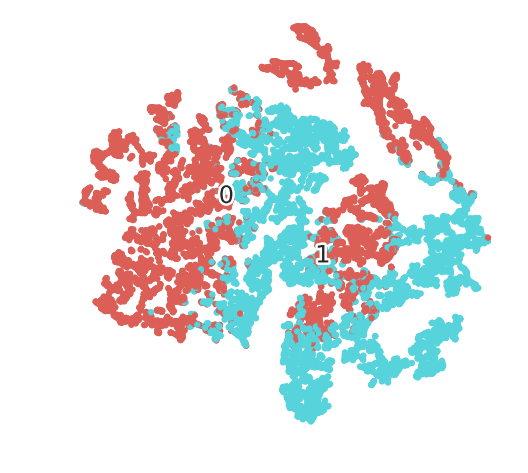

In [51]:
print(np.count_nonzero(bmap_targets))
_, _, _, _ = fashion_scatter(tsne_reduced, emap_targets, str_labels=['0', '1'])

7595


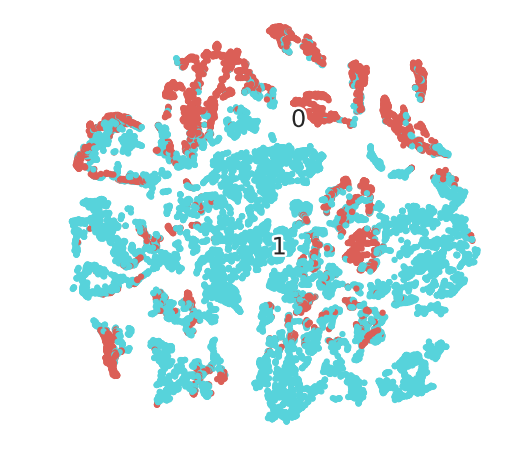

In [50]:
print(np.count_nonzero(emap_targets))
_, _, _, _ = fashion_scatter(tsne_dt, emap_targets, str_labels=['0', '1'])

In [38]:
from sklearn.decomposition import PCA

time_start = time.time()
pca = PCA(n_components=8)
pca_result = pca.fit_transform(target_features)

print("PCA done! Time elapsed: {} seconds".format(time.time()-time_start))

print("Variance explained per principal component: {}".format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 0.06626629829406738 seconds
Variance explained per principal component: [0.5528741  0.2967043  0.06258879 0.02264509 0.01928926 0.00838818
 0.00697479 0.00463803]


In [20]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

# fashion_tsne = TSNE(random_state=RS, n_components=2, perplexity=30, n_iter=1000).fit_transform(extended_features)

tsne_pca_comps = TSNE(random_state=RS, n_components=2, perplexity=30, n_iter=1000).fit_transform(pca_result)

print("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

t-SNE done! Time elapsed: 92.41215133666992 seconds


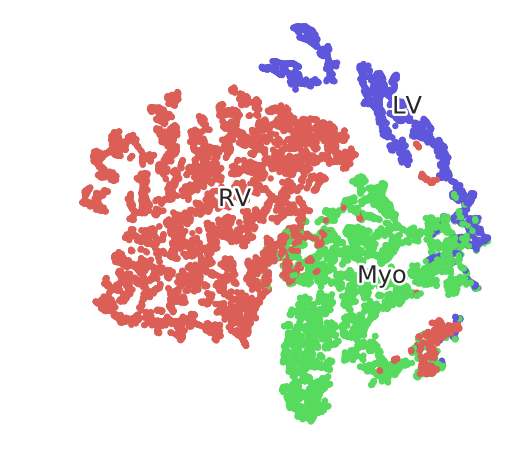

In [45]:
_, _, _, _ = fashion_scatter(tsne_reduced, adjusted_labels, str_labels=['RV', 'Myo', 'LV'])

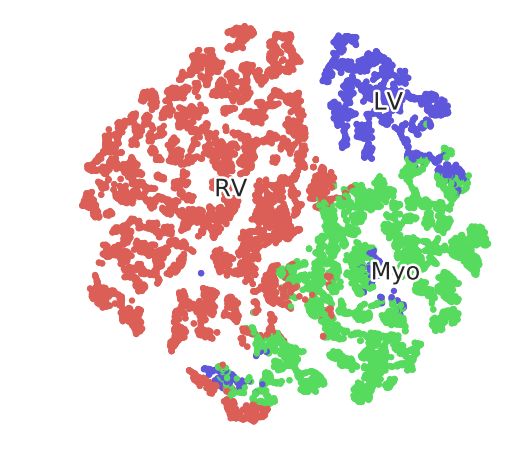

In [6]:
f, ax, sc, txts = fashion_scatter(fashion_tsne, adjusted_labels, str_labels=['RV', 'Myo', 'LV'])

In [33]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def fashion_scatter(x, colors, str_labels=None):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        if str_labels is None:
            class_label = str(i)
        else:
            class_label = str_labels[i]
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(4, 264, 198, 10) (4, 264, 198, 10) (10, 264, 198)
0


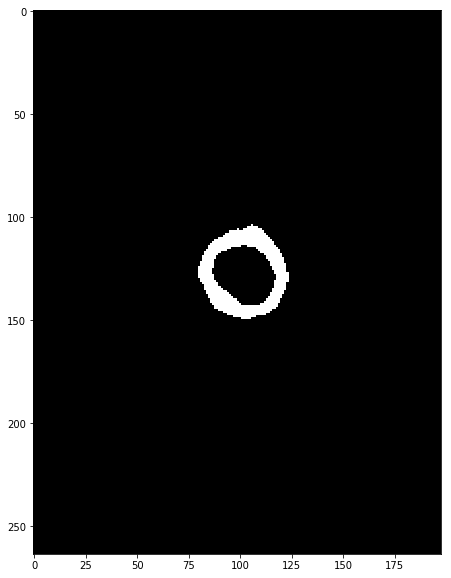

In [3]:
fname_targets = "/home/jorg/data/ACDC/brier/t_roi_maps/patient016_troi_map_frame12_mc.npz"
fname_pred_labels = "/home/jorg/data/ACDC/brier/pred_lbls/patient016_frame12_mc.npz"
fname_umap = "/home/jorg/data/ACDC/brier/u_maps/patient016_bmap_frame12.npz"

pred_labels = np.load(fname_pred_labels)['pred_labels']
target_errors = np.load(fname_targets)['target_roi']
bmap = np.load(fname_umap)['umap']
print(pred_labels.shape, target_errors.shape, bmap.shape)

slice_id = 8
cls_idx = 2

pred_labels_slice = pred_labels[cls_idx, :, :, slice_id]
target_error_slice = target_errors[cls_idx, :, :, slice_id]

print(np.count_nonzero(target_error_slice == 1))
pred_labels_slice[target_error_slice == 1] = 2

plt.rcParams['figure.figsize'] = [12.0, 10.0]
plt.imshow(pred_labels_slice, cmap=cm.gray)
plt.show()


(16, 151, 151)


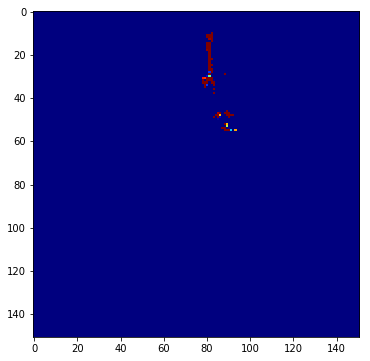

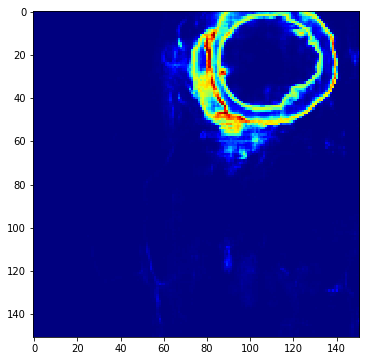

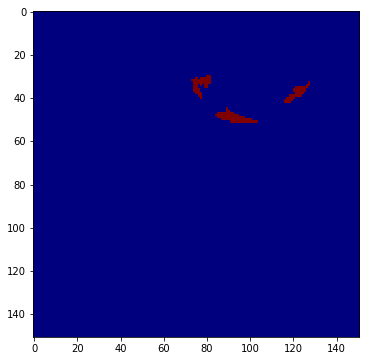

In [19]:
root_dir = "/home/jorg/repo/seg_eval_pipeline/logs/ACDC"
fname = os.path.join(root_dir, "20190409_11_21_dcnn_dt_separate_f0_brier_20KE_LowQualityDetection/doodle/")
fname = os.path.join(fname, "dt_probs_20000.npz")
data = np.load(fname)
dt_probs = data['dt_probs'][:, 1]
emap = data['entropy']
dt_maps = data['dt_maps']
filtered_seg_errors = data['seg_errors']
print(filtered_seg_errors.shape)
batch_slice = 0
dt_probs_slice = dt_probs[batch_slice]
emap_slice = emap[batch_slice]
dt_map_slice = dt_maps[batch_slice, 1]
seg_error_slice = filtered_seg_errors[batch_slice]

plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.imshow(dt_probs_slice, cmap=cm.jet)
plt.show()
plt.imshow(emap_slice, cmap=cm.jet)
plt.show()
plt.imshow(seg_error_slice, cmap=cm.jet)
plt.show()

In [5]:
fold_id = 0
data_handler = ACDCDataHandlerPhase(dcnn_config, loss_function="brier")
data_handler.get_acdc_images_labels(fold_id=fold_id, load_images=False, load_ref_labels=False)

Loading test dataset:   4%|▍         | 1/25 [00:00<00:03,  6.79it/s]/home/jorg/anaconda2/envs/pyt_1_0_0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Using SeparatePhaseVolume: 100%|██████████| 25/25 [00:00<00:00, 118082.88it/s]


In [3]:
output_dir = "/home/jorg/data/ACDC/detected_labels_3mm_newfilter/"

mydata = {}

for patient_id, frame_ids in heat_map_handler.heat_maps.items():
    for frame_id in frame_ids.keys():
        heat_map = heat_map_handler.get_heat_map(patient_id, frame_id=frame_id)
        target_labels = data_handler.get_detector_target_labels(patient_id, cardiac_phase=frame_id, 
                                                                mc_dropout=False, force_reload=False)
        # target labels [nclasses, x, y, z] we collapse first dim
        binary_targets = np.zeros_like(heat_map).astype(np.bool)
        filtered_heat_map = np.zeros_like(heat_map).astype(np.bool)
        binary_targets[np.sum(target_labels, axis=0) > 0] = True
        filtered_heat_map[heat_map >= 0.45] = True
        detector_map = np.logical_and(binary_targets, filtered_heat_map)
        undetected_idx = np.logical_and(binary_targets, ~detector_map)
        detector_map = detector_map.astype(np.int)
        # print("#Undetected {}".format(np.count_nonzero(undetected_idx)))
        detector_map[undetected_idx] = 2
        if patient_id == "patient100":
            mydata[frame_id] = tuple((heat_map, binary_targets, detector_map))
        data_handler.save_labels_to_nifti(patient_id, frame_id, detector_map.transpose((2, 0, 1)), output_dir)
        

[0 1 2]


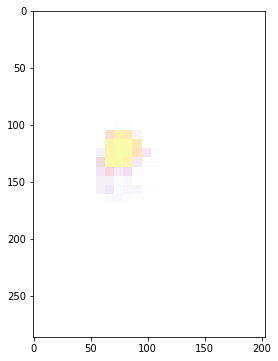

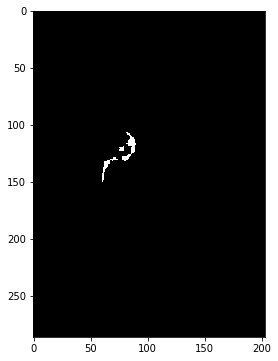

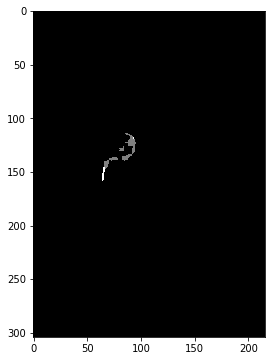

In [6]:
slice_id = 1
heat_map, binary_targets, _ = mydata[13]

fname = "/home/jorg/data/ACDC/detected_labels_3mm_newfilter/patient100_frame13.nii.gz"
myimage = sitk.ReadImage(fname)
detector_map = sitk.GetArrayFromImage(myimage).transpose((1, 2, 0))
print(np.unique(detector_map[:, :, slice_id]))


plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.imshow(heat_map[:, :, slice_id], cmap=mycmap)
plt.show()
plt.imshow(binary_targets[:, :, slice_id], cmap=cm.gray)
plt.show()
plt.imshow(detector_map[:, :, slice_id], cmap=cm.gray)
plt.show()